# Exploration of how do LLMs correct typos

## Setup

In [1]:
%pip install transformer_lens
%pip install circuitsvis
%pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 19.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import string
from typing import List, Callable, Literal
from functools import partial

from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login
from datasets import Dataset, DatasetDict, load_dataset
import torch
from torch import Tensor

import pandas as pd
from jaxtyping import Float, Int
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np

from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import (
    HookPoint,
)
import transformer_lens.utils as utils
import einops
import circuitsvis as cv


In [3]:
torch.set_grad_enabled(False)
login("your_hf_token")

## Load and test model

In [4]:
model = HookedTransformer.from_pretrained(
    #"meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-1B",
    #torch_dtype=torch.bfloat16,
    #dtype="bfloat16",
    device="cuda",
    fold_ln=True,
    center_writing_weights=True,
    center_unembed=True,
    fold_value_biases=True,
    #refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer


In [5]:
# check all activation and weights names
logits, cache = model.run_with_cache("the quick brown fox jumps over the lazy dog", remove_batch_dim=True, prepend_bos=True)
print(f"Number of tokens: {logits.shape[1]}")
for activation_name, activation in cache.cache_dict.items():
    # Only print for first layer
    if ".0." in activation_name or "blocks" not in activation_name:
        print(activation_name, activation.shape)

print()
for name, param in model.named_parameters():
    # Only print for first layer
    if ".0." in name or "blocks" not in name:
        print(name, param.shape)

Number of tokens: 10
hook_embed torch.Size([10, 2048])
blocks.0.hook_resid_pre torch.Size([10, 2048])
blocks.0.ln1.hook_scale torch.Size([10, 1])
blocks.0.ln1.hook_normalized torch.Size([10, 2048])
blocks.0.attn.hook_q torch.Size([10, 32, 64])
blocks.0.attn.hook_k torch.Size([10, 8, 64])
blocks.0.attn.hook_v torch.Size([10, 8, 64])
blocks.0.attn.hook_rot_q torch.Size([10, 32, 64])
blocks.0.attn.hook_rot_k torch.Size([10, 8, 64])
blocks.0.attn.hook_attn_scores torch.Size([32, 10, 10])
blocks.0.attn.hook_pattern torch.Size([32, 10, 10])
blocks.0.attn.hook_z torch.Size([10, 32, 64])
blocks.0.hook_attn_out torch.Size([10, 2048])
blocks.0.hook_resid_mid torch.Size([10, 2048])
blocks.0.ln2.hook_scale torch.Size([10, 1])
blocks.0.ln2.hook_normalized torch.Size([10, 2048])
blocks.0.mlp.hook_pre torch.Size([10, 8192])
blocks.0.mlp.hook_pre_linear torch.Size([10, 8192])
blocks.0.mlp.hook_post torch.Size([10, 8192])
blocks.0.hook_mlp_out torch.Size([10, 2048])
blocks.0.hook_resid_post torch.Size(

## Initial inspection of attention patterns

In [6]:
def visualize_attn_pattern(text, layer_idx):
    tokens = model.to_tokens(text, prepend_bos=True)
    logits, cache = model.run_with_cache(
        tokens,
        names_filter = lambda name: name.endswith("pattern"),
        remove_batch_dim=True,
        prepend_bos=False
    )

    attn_pattern = cache["pattern", layer_idx]
    display(cv.attention.attention_patterns(
        tokens=model.to_str_tokens(text, prepend_bos=True),
        attention=attn_pattern,
    ))

In [7]:
# 10 sentences with words that are split into mulitple tokens
multi_token_word_dataset = [
    "This implementation lacks comprehensiveness and adaptability.",
    "The castle was recaptured again.",
    "We discussed the counterproductive effects of micromanagement."
    "The preprocessed dataset was uploaded to the cloud.",
    "He enjoyed watching biographical documentaries about influential individuals.",
    "The miscommunication between departments caused delays in the project.",
    "Decentralization is key to improving efficiency in large organizations.",
    "Postmodernist literature often challenges traditional narrative structures.",
    "Their overenthusiastic response took everyone by surprise.",
    "The underutilized resources were eventually reallocated.",
]
# 10 random sentences
correct_dataset = [
    "The cat sat on the windowsill, watching the raindrops slide down the glass.",
    "After a long hike, they finally reached the summit and enjoyed the breathtaking view.",
    "She carefully folded the letter and placed it in a wooden box filled with old memories.",
    "The sound of laughter echoed through the park as children played on the swings.",
    "He glanced at his watch, realizing he was already late for the meeting.",
    "The aroma of freshly baked bread filled the kitchen, making everyone hungry.",
    "A sudden gust of wind scattered the leaves across the empty street.",
    "They spent the afternoon painting colorful murals on the school walls.",
    "His voice trembled as he delivered the speech in front of the large audience.",
    "The little girl held the balloon tightly, afraid it might float away."
]
# Sentences from above with typos introduced
typo_dataset = [
    "The catt sat on teh widowsill, watchign th raidrops slide downn the glas.",
    "Aftr a long hiek, they finaly reached teh sumit aand enjoyd the breathtakingg viev.",
    "She cacefully foldet te lettre and placd it in a woooden boc filed withh old memories.",
    "The sound of laughter echoed through the park as children played on the swings.",
    "He glancted at hhis watch, realiizng he was allready late fro the meeeting.",
    "The aroam of freshlyy baket bread filed tge kitcen, making every one hungry.",
    "A sudden gsut of windd scatered hte leeaves acros thee empty stret.",
    "Thye spent teh afternooon paniting colorfull muralss on the shcool walls.",
    "His voise trebled as he deliveret th spech in fronnt of he largee audience.",
    "The litle gilr held te ballooon tigthly, afraid it mighgt flat away."
]

In [8]:
# Combine the two datasets above to format Text: <typo_sentence> Corrected: <corect_sentence>
combined_typo_dataset = [f'Text: "{typo}" Corrected: "{correct}"' for typo, correct in zip(typo_dataset, correct_dataset)]

In [9]:
# Check attention patterns
text_typo = "What is hte maening of the word 'proprety'? It means" #add + " 1. property" and test loggit atribution on the last token pos (correct property)
text_correct = "What is the meaning of the word 'property'? It means"
text_multi = multi_token_word_dataset[1]
text = "What is the meaning of the word 'comptuer'? It means"
visualize_attn_pattern(text, 0)

#### Observations
- **L0H03** is subword merging head. I will try to explore its job in more detail

## Attention head ablation

In [10]:
def head_ablation_hook(
    value: Float[torch.Tensor, "batch seq_len n_heads d_head"],
    hook: HookPoint,
    head_idx: int,
    method: str = 'zero'
) -> Float[torch.Tensor, "batch seq_len n_heads d_head"]:
    #print(value.shape)
    if method == "zero":
        value[:, :, head_idx, :] = 0
    elif method == "mean":
        value[:, :, head_idx, :] = value[:, :, head_idx, :].mean(dim=1) #mean across seq_len?
    elif method == 'none':
        return value
    else:
        print("Invalid ablation method (accepts 'zero', 'mean' or 'none')")
    return value

def compute_loss_after_head_ablation(text, head_idx, layer_idx, method="zero", act_name="v", verbose=False):
    """
    Compare loss when specific activations are ablated.
    param method: either 'zero', 'mean' or 'none', defines how is the ablation done
    param act_name: name of the activation to ablate ('v' or 'q')
    """

    hook_fn = partial(head_ablation_hook, head_idx=head_idx, method=method)

    original_loss = model(text, return_type="loss")
    ablated_loss = model.run_with_hooks(
        text,
        return_type="loss",
        fwd_hooks=[(
            utils.get_act_name(act_name, layer_idx),
            hook_fn
        )]
    )
    if verbose:
        print(f"Original Loss: {original_loss.item():.3f}")
        print(f"Ablated Loss: {ablated_loss.item():.3f}")
    return original_loss.item(), ablated_loss.item()

In [11]:
compute_loss_after_head_ablation(
    text=text_typo,
    head_idx=3,
    layer_idx=0,
    method='zero',
    act_name="z",
    verbose=True
)

Original Loss: 4.441
Ablated Loss: 5.370


(4.441314220428467, 5.370491027832031)

**From quick experiments:** when ablating head L0H3 on text with typos, loss significantly increases. No other heads have this much influence on the loss. When ablating it on text without typos, the influence is minimal.

#### Comparision of loss after head ablation

disclaimer: I know that it would be faster and better to do it batched, but I would then need to handle padding and it would be more complex. Since I am still learning how to work with transformer lens, I will keep it sequential for simplicity (and maybe change it to batched later).

In [12]:
def get_ablation_loss_all_heads(text:str, normalize=True, method='zero') -> (List[List[float]], float):
    original_loss = model(text_typo, return_type="loss").item()
    loss_matrix = np.zeros((model.cfg.n_layers, model.cfg.n_heads)) #layer, head
    
    for layer_idx in range(model.cfg.n_layers):
        for head_idx in range(model.cfg.n_heads):
            _, ablated_loss = compute_loss_after_head_ablation(
                text=text,
                head_idx=head_idx,
                layer_idx=layer_idx,
                method=method,
                act_name="z",
                verbose=False
            )
            loss_matrix[layer_idx, head_idx] = ablated_loss

    if normalize:
        loss_matrix = (loss_matrix - np.min(loss_matrix)) / (np.max(loss_matrix) - np.min(loss_matrix))
    return loss_matrix, original_loss

def get_ablation_loss_all_heads_dataset(data: List[str], normalize=True) -> (List[List[float]], float):
    loss_matrix = np.zeros((len(data), model.cfg.n_layers, model.cfg.n_heads)) #batch, layer, head
    for idx, sample in tqdm(enumerate(data), total=len(data)):
        sample_loss_matrix, _ = get_ablation_loss_all_heads(sample, normalize)
        loss_matrix[idx] = sample_loss_matrix
    # Take mean across batch
    loss_matrix = einops.reduce(loss_matrix, "batch layer head -> layer head", "mean")
    return loss_matrix

In [13]:
loss_matrix_normal, _ = get_ablation_loss_all_heads("The answer to the ultimate question of life, the universe, and everything is")
loss_matrix_typo, _ = get_ablation_loss_all_heads("Teh ansewr to te ultimaate queston of lief, the univesre, andd evrything is")

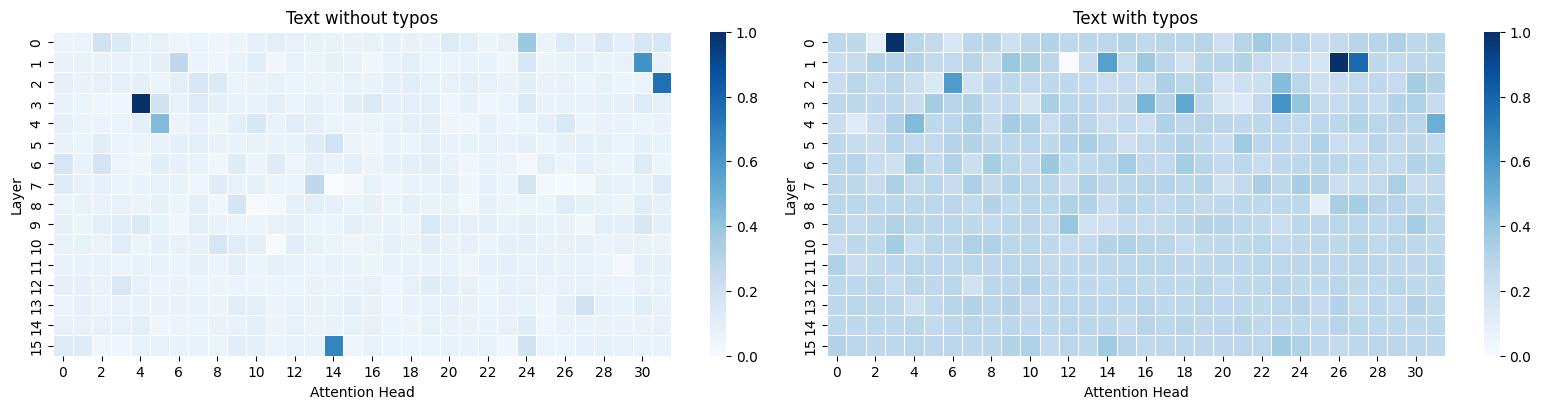

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.heatmap(loss_matrix_normal, cmap='Blues', linewidths=0.5, ax=axes[0])
axes[0].set_title("Text without typos")

sns.heatmap(loss_matrix_typo, cmap='Blues', linewidths=0.5, ax=axes[1])
axes[1].set_title("Text with typos")

plt.tight_layout()
for ax in axes:
    ax.set_xlabel("Attention Head")
    ax.set_ylabel("Layer")

plt.show()

This supports the claims above. Head L0H3 is the most significant head with regard to loss when there is a typo (at least based from few manual runs). Another important heads seem to be L1H26 and somewhat also L1H27. I will need to test this on more data.

I will follow up with mean loss difference across 10 samples from the combined_typo_dataset created earlier:

In [15]:
loss_matrix_dataset = get_ablation_loss_all_heads_dataset(combined_typo_dataset, normalize=True)

  0%|          | 0/10 [00:00<?, ?it/s]

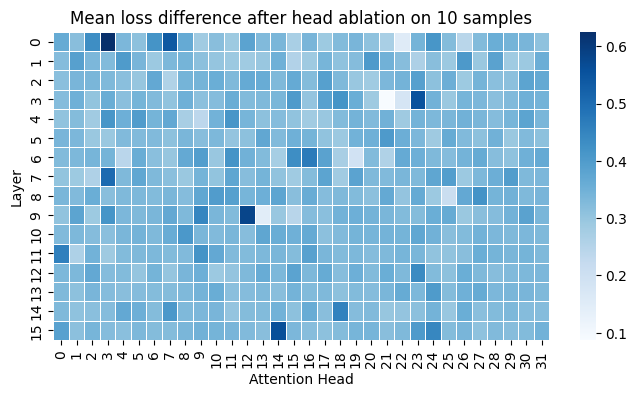

In [16]:
fig = plt.figure(figsize=(8, 4))
sns.heatmap(loss_matrix_dataset, cmap='Blues', linewidths=0.5)

plt.title("Mean loss difference after head ablation on 10 samples")
plt.xlabel("Attention Head")
plt.ylabel("Layer")

plt.show()

Lets try the same thing with dataset that doesn't contain typos.

In [17]:
loss_matrix_correct_dataset = get_ablation_loss_all_heads_dataset(correct_dataset, normalize=True)

  0%|          | 0/10 [00:00<?, ?it/s]

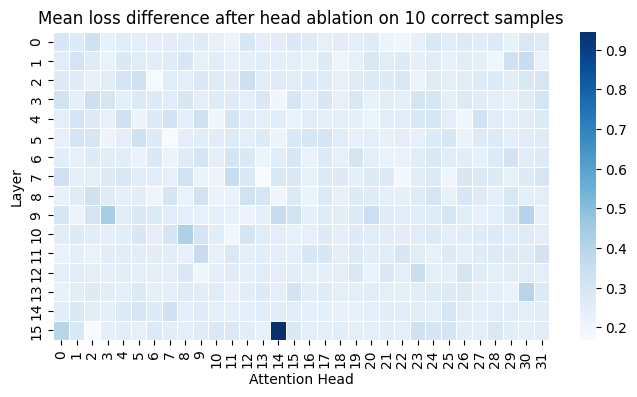

In [18]:
fig = plt.figure(figsize=(8, 4))
sns.heatmap(loss_matrix_correct_dataset, cmap='Blues', linewidths=0.5)

plt.title("Mean loss difference after head ablation on 10 correct samples")
plt.xlabel("Attention Head")
plt.ylabel("Layer")

plt.show()

Interestingly, a couple of different heads appeared when averaged across more samples. The subword merging head L0H3 is still there, but several new ones appeared. Head L15H14 appears even on correct samples, so it probably isn't related only to typos. But heads L0H7, L3H23 and L9H12 appear to make a difference on typos when ablated.

I will check out the attention patterns of those heads:

In [19]:
text = combined_typo_dataset[9]
#text = "induction head test underway, induction head test underway"
visualize_attn_pattern(text, 3)

- L0H6 seems to move information about prepositions, verbs, articles and their relationships to their nouns.
- L3H23 and L9H12 both look like current token heads. I don't know what their funciton might be.

Measuring the loss on the whole text is probably not the best metric, because in the first part of the text the model is predicting typos, which is not ideal. I will later repeat similar expirements with logit difference instead, which is better suited for this task.

## MLP ablation

Lets also quickly try to ablate the mlps and see what results does that yield.

In [20]:
def mlp_ablation_hook(
    mpl_out: Float[torch.Tensor, "batch seq_len d_model"],
    hook: HookPoint,
    method: str = 'zero'
) -> Float[torch.Tensor, "batch seq_len d_model"]:
    #print(value.shape)
    if method == "zero":
        mpl_out = 0
    elif method == "mean":
        mpl_out = mpl_out.mean(dim=1) #mean across seq_len?
    elif method == 'none':
        return mpl_out
    else:
        print("Invalid ablation method (accepts 'zero', 'mean' or 'none')")
    return mpl_out

def compute_loss_after_mlp_ablation(text, layer_idx, method="zero", verbose=False):
    """
    Compare loss when specific mlp outputs are ablated.
    param method: either 'zero', 'mean' or 'none', defines how is the ablation done
    """

    hook_fn = partial(mlp_ablation_hook, method=method)

    original_loss = model(text, return_type="loss")
    ablated_loss = model.run_with_hooks(
        text,
        return_type="loss",
        fwd_hooks=[(
            utils.get_act_name("mlp_out", layer_idx),
            hook_fn
        )]
    )
    if verbose:
        print(f"Original Loss: {original_loss.item():.3f}")
        print(f"Ablated Loss: {ablated_loss.item():.3f}")
    return original_loss.item(), ablated_loss.item()

In [21]:
def get_ablation_loss_all_mlps(text:str, normalize=True, method='zero') -> (List[List[float]], float):
    original_loss = model(text_typo, return_type="loss").item()
    loss_array = np.zeros((model.cfg.n_layers)) #layer
    
    for layer_idx in range(model.cfg.n_layers):
        _, ablated_loss = compute_loss_after_mlp_ablation(
            text=text,
            layer_idx=layer_idx,
            method=method,
            verbose=False
        )
        loss_array[layer_idx] = ablated_loss

    if normalize:
        loss_array = (loss_array - np.min(loss_array)) / (np.max(loss_array) - np.min(loss_array))
    return loss_array, original_loss

def get_ablation_loss_all_mlps_dataset(data: List[str], normalize=True, method='zero') -> (List[List[float]], float):
    loss_matrix = np.zeros((len(data), model.cfg.n_layers)) #batch, layer, head
    for idx, sample in tqdm(enumerate(data), total=len(data)):
        sample_loss_array, _ = get_ablation_loss_all_mlps(sample, normalize, method)
        loss_matrix[idx] = sample_loss_array
    # Take mean across batch
    final_loss_array = einops.reduce(loss_matrix, "batch layer -> layer", "mean")
    return final_loss_array

In [22]:
loss_array_dataset = get_ablation_loss_all_mlps_dataset(combined_typo_dataset, normalize=True)

  0%|          | 0/10 [00:00<?, ?it/s]

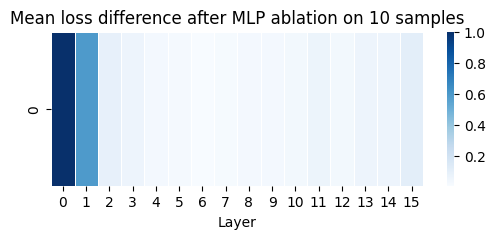

In [23]:
fig = plt.figure(figsize=(6, 2))
sns.heatmap(loss_array_dataset.reshape(1, -1), cmap='Blues', linewidths=0.5)

plt.title("Mean loss difference after MLP ablation on 10 samples")
plt.xlabel("Layer")

plt.show()

I will try the same thing with dataset wihtout typos, to verify if the behaviour above is general or related to typos.

In [24]:
loss_array_dataset_correct = get_ablation_loss_all_mlps_dataset(correct_dataset, normalize=True)

  0%|          | 0/10 [00:00<?, ?it/s]

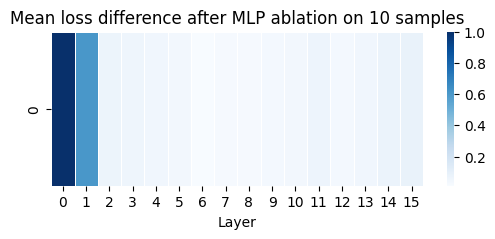

In [25]:
fig = plt.figure(figsize=(6, 2))
sns.heatmap(loss_array_dataset_correct.reshape(1, -1), cmap='Blues', linewidths=0.5)

plt.title("Mean loss difference after MLP ablation on 10 samples")
plt.xlabel("Layer")

plt.show()

The results seem the same, so I assume that the first two MLPs are generally important and not related to typos specifically.



## Generation with ablated head

In [26]:
def generate_with_hooks(
    text: str,
    fwd_hooks=[], 
    max_new_tokens: int = 30, 
    temperature: float = 0.0
) -> str:
    tokens = model.to_tokens(text, prepend_bos=True)
    for i in tqdm(range(max_new_tokens)):
        logits = model.run_with_hooks(tokens, fwd_hooks=fwd_hooks, return_type="logits")
        new_tok = logits[:, -1, :].argmax()
        #append new token
        tokens = torch.cat((tokens, torch.tensor([[new_tok]]).to("cuda")), dim=1)
        #Break on eos
        if model.to_string(new_tok) == model.tokenizer.eos_token:
            break
    return model.to_string(tokens)

def generate_with_ablated_head(
    text: str,
    head_idx: int,
    method: Literal["zero", "mean", "none"],
    layer_idx: int,
    act_name: str,
    max_new_tokens: int = 30,
    temperature: float = 0.0
) -> str:
    hook_fn = partial(head_ablation_hook, head_idx=head_idx, method=method)
    return generate_with_hooks(
        text,
        fwd_hooks=[
            (utils.get_act_name(act_name, layer_idx), hook_fn),
        ],
        max_new_tokens = max_new_tokens,
        temperature = temperature
    )

In [27]:
text = "What is the meaning of the word 'comptuer'? It means"

In [28]:
print("When head L0H3 is ablated:")
generate_with_ablated_head(text, head_idx=3, method="zero", layer_idx=0, act_name="z")

When head L0H3 is ablated:


  0%|          | 0/30 [00:00<?, ?it/s]

['<|begin_of_text|>What is the meaning of the word \'comptuer\'? It means to be a part of something. It is a verb. It is used in the sentence "I am a part of the team". It is used']

In [29]:
print("Without ablation:")
generate_with_ablated_head(text, head_idx=3, method="none", layer_idx=0, act_name="z")

Without ablation:


  0%|          | 0/30 [00:00<?, ?it/s]

["<|begin_of_text|>What is the meaning of the word 'comptuer'? It means a computer. It is a machine that can do calculations. It is a machine that can do calculations. It is a machine that can do calculations."]

When I ablate the subword merging head and try to generate stuff, it degrades the perfomance on sentences with typos, but makes almost zero difference on normal sentences. This makes sense, since the typos are tokenized into mulitple tokens, which then need to be merged together to get the correct meaning.

## Generate with ablated MLP

In [30]:
def generate_with_ablated_mlp(
    text: str,
    layer_idx: int,
    method: Literal["zero", "mean", "none"]="zero",
    max_new_tokens: int = 30,
    temperature: float = 0.0
) -> str:
    hook_fn = partial(mlp_ablation_hook, method=method)
    return generate_with_hooks(
        text,
        fwd_hooks=[
            (utils.get_act_name("mlp_out", layer_idx), hook_fn),
        ],
        max_new_tokens = max_new_tokens,
        temperature = temperature
    )

In [31]:
text = correct_dataset[0]
generate_with_ablated_mlp(text, 0, "zero")

  0%|          | 0/30 [00:00<?, ?it/s]

['<|begin_of_text|>The cat sat on the windowsill, watching the raindrops slide down the glass. 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1']

**Observation**

MLP0 and MLP1 seem important for all tasks and their ablation completely breaks the model.

## Explore what is copied by the attention head (logit lens)
I will try to unembed the outputs of the subword merging attention head to see if there is anything meaningful. This doesn't have to yield any interpretable results, since the representation of the information moved by the heads doesn't have to be in a interpretable form by the unembed matrix.

I will unembed the output of a given attention head with the unembeding matrix and also try to do it with the inverse of embedding matrix. I will also compare cosine similarity between the output and relevant tokens.

In [32]:
def get_attn_out(
    cache: ActivationCache,
    token_idx: int,
    head_idx: int,
    layer_idx: int
) -> Float[torch.Tensor, "d_model"]:
    # select the z vector (output of attn block in attn space)
    z = cache["z", layer_idx]
    # select token and head idx
    z = z[token_idx, head_idx, :] #shape d_head (single activation value)
    #shape W_O: layer, n_head, d_head, d_model
    w_o = model.W_O[layer_idx, head_idx, :, :] #shape w_o: d_head, d_model
    # Get heads contribution to the residual stream
    attn_head_out = einops.einsum(z, w_o, "d_head, d_head d_model -> d_model") + model.b_O[layer_idx] #shape: d_model
    return attn_head_out

def verify_compared_tokens(
    str_tokens_to_compare: List[str]
) -> List[str]:
    # tokens sometimes have space before them, try adding that
    for str_token in str_tokens_to_compare[:]:
        str_tokens_to_compare.append(" " + str_token)
    return [str_token for str_token in str_tokens_to_compare if len(model.to_str_tokens(str_token, prepend_bos=False)) == 1]

def compare_unembed_str(
    str_tokens_to_compare: List[str],
    attn_out: Float[torch.Tensor, "d_model"],
    top_k: int = 200,
    print_top_k: int = 20
) -> None:
    
    logits = model.unembed(attn_out)
    # Check if the tokens to compare are in topk logits
    logits, indices = torch.topk(logits, k=top_k)
    for str_token in str_tokens_to_compare:
        token = model.to_tokens(str_token, prepend_bos=False)
        if token not in indices:
            #print(f"Token |{str_token}| is not in the top {top_k} tokens when unembedding.")
            continue
        print(f"Token |{str_token}| belongs to {list(indices).index(token)}. biggest logit")
        
    print(f"{print_top_k} most probable tokens:")
    for logit, token in zip(logits[:print_top_k], indices[:print_top_k]):
        print(f"TOKEN |{model.to_str_tokens(token, prepend_bos=False)[0]}|, logit value: {logit:.4f}")
        
    # Try inverse of embedding matrix (just an experiment, probable won't give anything sensible)
    inverse_logits = einops.einsum(attn_out, model.W_E.T, "d_model, d_model d_vocab -> d_vocab")
    inverse_logits, inverse_indices = torch.topk(inverse_logits, k=top_k)
    print(f"{print_top_k} most probable tokens from inversed embedding matrix:")
    for logit, token in zip(inverse_logits[:print_top_k], inverse_indices[:print_top_k]):
        print(f"TOKEN |{model.to_str_tokens(token, prepend_bos=False)[0]}|, logit value: {logit:.4f}")

def compare_embeddings(
    str_tokens_to_compare: List[str],
    attn_out: Float[torch.Tensor, "d_model"],
) -> None:
    """Compute cosine simillary between the embeddings (and unembeding directions) 
    and the output of the attention head
    """
    # get embedding and unembedding vector for each token
    for str_token in str_tokens_to_compare:
        # Embedding
        token = model.to_tokens(str_token, prepend_bos=False)[0]
        embed = model.embed(token).squeeze()
        # vector in the unembed that corresponds to the given token
        unembed = model.W_U[:, token].squeeze()
        # check if directins are similar
        cos_sim = torch.nn.CosineSimilarity(dim=-1)
        if cos_sim(attn_out, embed).item() > 0.05:
            print(f"Cosine similarity of embed |{str_token}| with attn_out: {cos_sim(attn_out, embed).item():.4f}")
        if cos_sim(attn_out, unembed).item() > 0.05:
            print(f"Cosine similarity of unembed |{str_token}| with attn_out: {cos_sim(attn_out, unembed).item():.4f}")


def compare_similarity(
    cache: ActivationCache,
    token_idx: int,
    str_tokens_to_compare: List[str],
    head_idx: int,
    layer_idx: int,
    text: str
) -> None:
    str_tokens_text = model.to_str_tokens(text)
    print(f"Inspected text:\n{'|'.join(str_tokens_text)}")
    print(f"Inspecting L{layer_idx}H{head_idx} at token position {token_idx} (token |{str_tokens_text[token_idx]}|)", "\n")
    str_tokens_to_compare = verify_compared_tokens(str_tokens_to_compare)
    attn_head_out = get_attn_out(cache, token_idx, head_idx, layer_idx)
    
    #token_probs = torch.softmax(logits, dim=-1)
    compare_unembed_str(str_tokens_to_compare, attn_head_out)
    compare_embeddings(str_tokens_to_compare, attn_head_out)

In [33]:
#text = "What is the meaning of the word 'proprety'? It means"
text = "What is the meaning of the word 'comptuer'? It means"
model.generate(text, max_new_tokens=30, temperature=0.0, prepend_bos=True)

  0%|          | 0/30 [00:00<?, ?it/s]

"What is the meaning of the word 'comptuer'? It means a computer. It is a machine that can do calculations. It is a machine that can do calculations. It is a machine that can do calculations."

In [34]:
logits, cache = model.run_with_cache(text, remove_batch_dim=True, prepend_bos=True)

In [35]:
compared_tokens = ["computer", "comp", "cop", "machine", "com", "compute", "Computer"]

compare_similarity(
    cache=cache,
    token_idx=11,
    str_tokens_to_compare=compared_tokens,
    head_idx=3,
    layer_idx=0,
    text=text
)

Inspected text:
<|begin_of_text|>|What| is| the| meaning| of| the| word| '|com|pt|uer|'?| It| means
Inspecting L0H3 at token position 11 (token |uer|) 

20 most probable tokens:
TOKEN | tune|, logit value: 0.1176
TOKEN | Tune|, logit value: 0.1083
TOKEN | Tat|, logit value: 0.1004
TOKEN | tolerance|, logit value: 0.0979
TOKEN | tunes|, logit value: 0.0971
TOKEN | either|, logit value: 0.0932
TOKEN |탈|, logit value: 0.0916
TOKEN | Tun|, logit value: 0.0890
TOKEN | tal|, logit value: 0.0888
TOKEN |cade|, logit value: 0.0883
TOKEN | tuning|, logit value: 0.0878
TOKEN | tast|, logit value: 0.0870
TOKEN |deş|, logit value: 0.0870
TOKEN | tuned|, logit value: 0.0856
TOKEN | Exhibit|, logit value: 0.0855
TOKEN | tako|, logit value: 0.0855
TOKEN |terraform|, logit value: 0.0850
TOKEN | Tol|, logit value: 0.0847
TOKEN | pinned|, logit value: 0.0845
TOKEN | Princip|, logit value: 0.0841
20 most probable tokens from inversed embedding matrix:
TOKEN | tune|, logit value: 0.0379
TOKEN | Tune|, logi

It doesn't provide much insight. I hoped that I would see the subwords that are being moved between the tokens, but that is rarely the case.

### Try unembedding from residual stream
I will try to do the same thing, but from the residual stream instead of the head outputs.

In [36]:
def unembed_resid(
    cache: ActivationCache,
    layer_idx: int,
    token_idx: int,
    top_k: int = 20,
) -> None:
    # check resid stream undembeddings before and after MLP
    for act_name in ["resid_pre", "resid_mid"]:
        logits = model.unembed(cache[act_name, layer_idx][token_idx])
        logits, indices = torch.topk(logits, k=top_k)

        print(f"{top_k} biggest logits after unembed from L{layer_idx}, {act_name}:")
        for logit, token in zip(logits[:top_k], indices[:top_k]):
            print(f"TOKEN |{model.to_str_tokens(token, prepend_bos=False)[0]}|, logit value: {logit:.4f}")
            
    # check output of attention layer
    logits = model.unembed(cache["attn_out", layer_idx][token_idx])
    logits, indices = torch.topk(logits, k=top_k)
    print(f"{top_k} biggest logits after unembed L{layer_idx}, ATTN_OUT:")
    for logit, token in zip(logits[:top_k], indices[:top_k]):
        print(f"TOKEN |{model.to_str_tokens(token, prepend_bos=False)[0]}|, logit value: {logit:.4f}")
        
     # check output of MLP layer
    logits = model.unembed(cache["mlp_out", layer_idx][token_idx])
    logits, indices = torch.topk(logits, k=top_k)
    print(f"{top_k} biggest logits after unembed L{layer_idx}, MLP_OUT:")
    for logit, token in zip(logits[:top_k], indices[:top_k]):
        print(f"TOKEN |{model.to_str_tokens(token, prepend_bos=False)[0]}|, logit value: {logit:.4f}")

In [37]:
#text = "What is the meaning of the word 'proprety'? It means"
#text = "What is the meaning of the word 'recapture'? It means"
#text = "'pinapple'? Do you mean '"
output = model.generate(text, max_new_tokens=15, temperature=0.0, prepend_bos=True)
print(output, "\n")
print(f"Inspected text:\n{'|'.join(model.to_str_tokens(text))}")

logits, cache = model.run_with_cache(text, remove_batch_dim=True, prepend_bos=True)

  0%|          | 0/15 [00:00<?, ?it/s]

What is the meaning of the word 'comptuer'? It means a computer. It is a machine that can do calculations. It is a 

Inspected text:
<|begin_of_text|>|What| is| the| meaning| of| the| word| '|com|pt|uer|'?| It| means


In [38]:
unembed_resid(
    cache,
    layer_idx=0,
    token_idx=11,
    top_k=5
)

5 biggest logits after unembed from L0, resid_pre:
TOKEN |uer|, logit value: 2.7866
TOKEN |uers|, logit value: 1.4462
TOKEN |uen|, logit value: 0.8033
TOKEN |uet|, logit value: 0.7923
TOKEN |ué|, logit value: 0.7648
5 biggest logits after unembed from L0, resid_mid:
TOKEN |uer|, logit value: 2.7275
TOKEN |uers|, logit value: 1.4283
TOKEN |uen|, logit value: 0.7768
TOKEN |ué|, logit value: 0.7371
TOKEN |uet|, logit value: 0.7341
5 biggest logits after unembed L0, ATTN_OUT:
TOKEN | both|, logit value: 0.1629
TOKEN | cross|, logit value: 0.1571
TOKEN | either|, logit value: 0.1539
TOKEN | in|, logit value: 0.1533
TOKEN | Tub|, logit value: 0.1499
5 biggest logits after unembed L0, MLP_OUT:
TOKEN |onga|, logit value: 0.3673
TOKEN |mark|, logit value: 0.3166
TOKEN |IRO|, logit value: 0.3104
TOKEN |iment|, logit value: 0.3088
TOKEN |oid|, logit value: 0.3018


This also didn't provide me with any interpretable insights.

## Logit difference analysis
I will measure the logit difference when specific parts of the model are ablated.

The typos can be roughly grouped by the following conditions:
- **location** of the typo
  - the tokenized word with typo has the typo in the first token
  - the tokenized word with typo has the typo in the last token
  - Sidenote: changes could be also in the middle tokens for some words, however I think that would be simillar to the above
- **type** of the typo
  - missing letter
  - additional letter
  - switching letters
  - Sidenote: this list is not exhaustive, but these are the most common typos

For each of these I will create a dataset of 30 samples. I will use the same words across all of them.

## Data creation

In [39]:
original_data = [
    ["incorrect: apple, correct:", " apple"],  
    ["incorrect: running, correct:", " running"],  
    ["incorrect: beautiful, correct:", " beautiful"],  
    ["incorrect: mountain, correct:", " mountain"],  
    ["incorrect: quickly, correct:", " quickly"],  
    ["incorrect: happiness, correct:", " happiness"],  
    ["incorrect: elephant, correct:", " elephant"],  
    ["incorrect: sleeping, correct:", " sleeping"],  
    ["incorrect: delicious, correct:", " delicious"],  
    ["incorrect: discovery, correct:", " discovery"],  
    ["incorrect: football, correct:", " football"],  
    ["incorrect: mysterious, correct:", " mysterious"],  
    ["incorrect: celebration, correct:", " celebration"],  
    ["incorrect: dance, correct:", " dance"],  
    ["incorrect: enormous, correct:", " enormous"],  
    ["incorrect: friendship, correct:", " friendship"],  
    ["incorrect: whisper, correct:", " whisper"],  
    ["incorrect: adventurous, correct:", " adventurous"],  
    ["incorrect: creativity, correct:", " creativity"],  
    ["incorrect: computer, correct:", " computer"],  
    ["incorrect: exploring, correct:", " exploring"],  
    ["incorrect: courageous, correct:", " courageous"],  
    ["incorrect: imagination, correct:", " imagination"],  
    ["incorrect: swimming, correct:", " swimming"],  
    ["incorrect: wonderful, correct:", " wonderful"],  
    ["incorrect: storytelling, correct:", " storytelling"],  
    ["incorrect: exciting, correct:", " exciting"],  
    ["incorrect: kindness, correct:", " kindness"],  
    ["incorrect: fascinating, correct:", " fascinating"],
    ["incorrect: technology, correct:", " technology"]
]
print(len(original_data))

30


In [40]:
# verify tokenization
for sentence, correct in original_data:
    str_tokens_correct = model.to_str_tokens(correct, prepend_bos=False)
    str_tokens_sentence = model.to_str_tokens(sentence, prepend_bos=False)
    # check that correct is only one token
    if len(str_tokens_correct) != 1:
        print(str_tokens_correct)
    # check that in the first sentence it is also as one same token
    if [str_tokens_sentence[2]] != str_tokens_correct:
        print(str_tokens_sentence)

In [41]:
def make_typo(
    word: str, 
    typo_type: Literal["del", "add", "switch"],
    end_location: bool|None =False # if set to None, it will be random
) -> str:
    """
    Function that adds typo to a given word. The first character of the word won't be changed, since space is expected for tokenization.
    """
    str_tokens = [word] #placeholder
    #while (end_location and str_tokens[-1] == word[-len(str_tokens[-1]):]) or (not end_location and str_tokens[0] == word[:len(str_tokens[0])]):
    if typo_type == "del":
        if end_location is None:
            idx = random.randint(1, len(word) - 1)
        else:
            idx = len(word) - 1 if end_location else 1
        typo = word[:idx] + word[idx+1:]
        str_tokens = model.to_str_tokens(typo, prepend_bos=False)
    elif typo_type == "add":
        if end_location is None:
            idx = random.randint(0, len(word) - 1)
        else:
            idx = len(word) - 1 if end_location else 0
        random_letter = random.choice(string.ascii_lowercase)
        typo = word[:idx+1] + random_letter + word[idx+1:]
        str_tokens = model.to_str_tokens(typo, prepend_bos=False)
    elif typo_type == "switch":
        if end_location is None:
            idx = random.randint(1, len(word) - 2) # idx to switch with following
        else:
            idx = len(word) - 2 if end_location else 1
        typo = word[:idx] + word[idx+1] + word[idx] + word[idx+2:]
        str_tokens = model.to_str_tokens(typo, prepend_bos=False)
    return typo

def create_dataset(
    correct_data: List[List[str]],
    typo_type: Literal["del", "add", "switch"],
    end_location: bool=False,
    word_idx: int=2 # position of the correct word in the first sentece
) -> List[List[str]]:
    typo_data = []
    for sentence, correct in correct_data:
        str_tokens = model.to_str_tokens(sentence, prepend_bos=False)
        str_tokens[word_idx] = make_typo(correct, typo_type, end_location)
        typo_data.append(["".join(str_tokens), correct])
    return typo_data

In [42]:
del_start = create_dataset(original_data, "del", end_location=False)
del_end = create_dataset(original_data, "del", end_location=True)
add_start = create_dataset(original_data, "add", end_location=False)
add_end = create_dataset(original_data, "add", end_location=True)
switch_start = create_dataset(original_data, "switch", end_location=False)
switch_end = create_dataset(original_data, "switch", end_location=True)

In [43]:
# Verify that the model can correctly predict those
for text, correct in del_end:
    logits = model(text, return_type="logits")
    new_tok = logits[:, -1, :].argmax()
    new_word = model.to_string(new_tok)
    # This is not entirely correct, the model could generate the correct word from smaller subtokens
    # Howeveror for simplicity this approach is used for now
    if new_word != correct:
        print(f"[WRONG] predicted token: '{new_word}', correct word: '{correct}', sentence: {text}")
    else:
        print(f"[CORRECT] predicted token: '{new_word}', correct word: '{correct}', sentence: {text}")

[WRONG] predicted token: ' ap', correct word: ' apple', sentence: incorrect: appl, correct:
[CORRECT] predicted token: ' running', correct word: ' running', sentence: incorrect: runnin, correct:
[CORRECT] predicted token: ' beautiful', correct word: ' beautiful', sentence: incorrect: beautifu, correct:
[CORRECT] predicted token: ' mountain', correct word: ' mountain', sentence: incorrect: mountai, correct:
[WRONG] predicted token: ' quick', correct word: ' quickly', sentence: incorrect: quickl, correct:
[CORRECT] predicted token: ' happiness', correct word: ' happiness', sentence: incorrect: happines, correct:
[CORRECT] predicted token: ' elephant', correct word: ' elephant', sentence: incorrect: elephan, correct:
[CORRECT] predicted token: ' sleeping', correct word: ' sleeping', sentence: incorrect: sleepin, correct:
[CORRECT] predicted token: ' delicious', correct word: ' delicious', sentence: incorrect: deliciou, correct:
[WRONG] predicted token: ' discover', correct word: ' discove

Unfortunately this doesn't work as expected.

## Make it less ambitious and create only two datasets
Since the model cannot correct some of the typos above, I will simplify the task:
- Only two dataset
  - typos where last letter is missing
  - typos where the last two letters are switched
- I will create the datasets manually and only include samples, where the model correctly corrects the whole word in one token.

In [44]:
del_end = [
    #["incorrect: purpl, correct:", " purple"],  
    ["incorrect: runnin, correct:", " running"],  
    ["incorrect: beautifu, correct:", " beautiful"],  
    ["incorrect: mountai, correct:", " mountain"],  
    ["incorrect: keyboar, correct:", " keyboard"],  
    ["incorrect: happines, correct:", " happiness"],  
    ["incorrect: elephan, correct:", " elephant"],  
    #["incorrect: sleepin, correct:", " sleeping"],  
    ["incorrect: deliciou, correct:", " delicious"],  
    ["incorrect: discove, correct:", " discover"],  
    ["incorrect: footbal, correct:", " football"],  
    ["incorrect: mysteriou, correct:", " mysterious"],  
    #["incorrect: celebratio, correct:", " celebration"],  
    ["incorrect: athlet, correct:", " athlete"],  
    ["incorrect: friendshi, correct:", " friendship"],  
    ["incorrect: whisper, correct:", " whisper"],  
    ["incorrect: Tuesda, correct:", " Tuesday"],  
    ["incorrect: hurrican, correct:", " hurricane"],  
    ["incorrect: tsunam, correct:", " tsunami"],  
    #["incorrect: swimmin, correct:", " swimming"],  
    ["incorrect: wonderfu, correct:", " wonderful"],  
    ["incorrect: storytellin, correct:", " storytelling"],  
    ["incorrect: kindnes, correct:", " kindness"],  
    ["incorrect: technolog, correct:", " technology"]
]
print("len del_end", len(del_end))
switch_end = [
    ["incorrect: runnign, correct:", " running"],  
    ["incorrect: sleepign, correct:", " sleeping"],  
    ["incorrect: celebratino, correct:", " celebration"],  
    ["incorrect: creativiyt, correct:", " creativity"],  
    ["incorrect: computre, correct:", " computer"],  
    ["incorrect: explorign, correct:", " exploring"],  
    ["incorrect: technoloyg, correct:", " technology"],
    ["incorrect: repetitino, correct:", " repetition"],
    ["incorrect: exampel, correct:", " example"],
    ["incorrect: banaan, correct:", " banana"],
    ["incorrect: bicycel, correct:", " bicycle"],
    ["incorrect: tabel, correct:", " table"],
    ["incorrect: pictuer, correct:", " picture"],
    ["incorrect: weathre, correct:", " weather"],
    ["incorrect: statisticla, correct:", " statistical"],
    ["incorrect: physisc, correct:", " physics"],
    ["incorrect: ligth, correct:", " light"],
    ["incorrect: weigth, correct:", " weight"],
    ["incorrect: obesiyt, correct:", " obesity"],
    ["incorrect: conversatino, correct:", " conversation"],
]
print("len switch_end", len(switch_end))

len del_end 20
len switch_end 20


In [45]:
# add incorrect token to the datsets
def add_incorrect_token(dataset: List[List[str]], word_idx = 2) -> None:
    for i in range(len(dataset)):
        sentence, correct = dataset[i]
        str_tokens = model.to_str_tokens(sentence, prepend_bos=False)
        typo = str_tokens[word_idx]
        #append first token of the word with a typo
        dataset[i].append(model.to_str_tokens(typo, prepend_bos=False)[0])

In [46]:
add_incorrect_token(switch_end)
add_incorrect_token(del_end)

## Logit difference after head ablation
The following code computes logit difference between the correct token (whole correct word) and incorrect token (the first token of the word with a typo). This format isn't completely ideal, since the model can output the correct word even when it is tokenized into multiple words, but hopefully it will give resonable results.

In [47]:
def compute_logit_diff_after_head_ablation(
    text: str, 
    head_idx: int, 
    layer_idx: int, 
    correct_tok: str, 
    incorrect_tok: str, 
    method: Literal["zero", "mean", "none"]="zero", 
    act_name:str="z",
    verbose: bool=False
) -> float:
    """
    Compare loss when specific activations are ablated.
    param method: either 'zero', 'mean' or 'none', defines how is the ablation done
    param act_name: name of the activation to ablate
    """

    hook_fn = partial(head_ablation_hook, head_idx=head_idx, method=method)

    logits = model.run_with_hooks(
        text,
        return_type="logits",
        fwd_hooks=[(
            utils.get_act_name(act_name, layer_idx),
            hook_fn
        )]
    )
    
    logits = logits[0, -1, :]
    correct_tok = model.to_tokens(correct_tok, prepend_bos=False)[0]
    incorrect_tok = model.to_tokens(incorrect_tok, prepend_bos=False)[0]
    logit_diff = (logits[correct_tok] - logits[incorrect_tok]).item()
    if verbose:
        print(f"Given sentence: {text}")
        print(f"Predicted token: {model.to_string(logits.argmax())}")
        print(f"Correct logit: {logits[correct_tok].item()}, Incorrect logit: {logits[incorrect_tok].item()}")
        print(f"Logit diff: {logit_diff}")
    return logit_diff

In [48]:
def normalize_matrix(matrix, baseline):
    shifted = matrix - baseline
    max_abs_value = np.max(np.abs(shifted))
    if max_abs_value == 0:
        return np.zeros_like(matrix)  # Handle the case when all values are the same as the baseline
    normalized = shifted / max_abs_value
    return normalized

In [49]:
def get_logit_diff_all_heads(
    text:str, 
    correct_tok: str, 
    incorrect_tok: str, 
    normalize=True, 
    method='zero'
) -> (List[List[float]], float):
    diff_matrix = np.zeros((model.cfg.n_layers, model.cfg.n_heads)) #layer, head
    #get logit diff without any ablation
    logit_diff_base = compute_logit_diff_after_head_ablation(
            text=text,
            head_idx=0, # placeholder value
            layer_idx=0, # placeholder value
            correct_tok=correct_tok,
            incorrect_tok=incorrect_tok,
            method="none",
            verbose=False
        )

    # Compute logit for each head ablated
    for layer_idx in range(model.cfg.n_layers):
        for head_idx in range(model.cfg.n_heads):
            logit_diff = compute_logit_diff_after_head_ablation(
                text=text,
                head_idx=head_idx,
                layer_idx=layer_idx,
                correct_tok=correct_tok,
                incorrect_tok=incorrect_tok,
                method=method,
                verbose=False
            )
            diff_matrix[layer_idx, head_idx] = logit_diff
     
    if normalize:
        diff_matrix = normalize_matrix(diff_matrix, logit_diff_base)
    return diff_matrix, logit_diff_base

def get_logit_diff_all_heads_dataset(data: List[List[str]], normalize=True) -> (List[List[float]], float):
    diff_matrix = np.zeros((len(data), model.cfg.n_layers, model.cfg.n_heads)) #batch, layer, head
    for idx, (sentence, correct, incorrect) in tqdm(enumerate(data), total=len(data)):
        sample_diff_matrix, _ = get_logit_diff_all_heads(sentence, correct, incorrect, normalize)
        diff_matrix[idx] = sample_diff_matrix
    # Take mean across batch
    diff_matrix = einops.reduce(diff_matrix, "batch layer head -> layer head", "mean")
    return diff_matrix

In [50]:
diff_matrix_del = get_logit_diff_all_heads_dataset(del_end)

  0%|          | 0/20 [00:00<?, ?it/s]

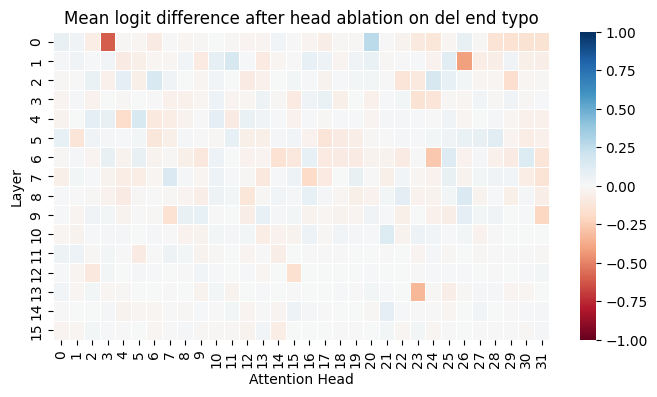

In [101]:
fig = plt.figure(figsize=(8, 4))
sns.heatmap(diff_matrix_del, cmap="RdBu", linewidths=0.5, vmin=-1, vmax=1)

plt.title("Mean logit difference after head ablation on del end typo")
plt.xlabel("Attention Head")
plt.ylabel("Layer")

plt.show()

In [52]:
diff_matrix_switch = get_logit_diff_all_heads_dataset(switch_end)

  0%|          | 0/20 [00:00<?, ?it/s]

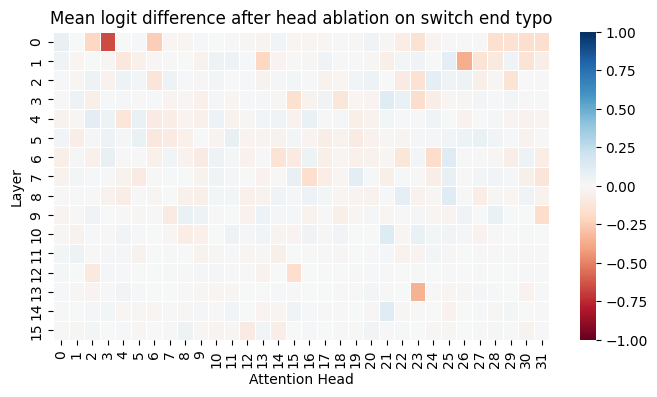

In [102]:
fig = plt.figure(figsize=(8, 4))
sns.heatmap(diff_matrix_switch, cmap="RdBu", linewidths=0.5, vmin=-1, vmax=1)

plt.title("Mean logit difference after head ablation on switch end typo")
plt.xlabel("Attention Head")
plt.ylabel("Layer")

plt.show()

Important heads:
- **L0H3** - subword merging head
- **L1H26** - subwords and "phrases" (sound of, the, ...)
- L13H23 - Induction head

#### Explore patterns for the interesting heads

In [54]:

#visualize_attn_pattern(typo_dataset[0], 1)

## Logit difference after mlp ablation

In [55]:
def compute_logit_diff_after_mlp_ablation(
    text: str, 
    layer_idx: int,
    correct_tok: str,
    incorrect_tok: str,
    method="zero", 
    verbose=False
) -> float:
    """
    Compare logit diff when specific mlp outputs are ablated.
    param method: either 'zero', 'mean' or 'none', defines how is the ablation done
    """

    hook_fn = partial(mlp_ablation_hook, method=method)

    logits = model.run_with_hooks(
        text,
        return_type="logits",
        fwd_hooks=[(
            utils.get_act_name("mlp_out", layer_idx),
            hook_fn
        )]
    )
    # remove batch dim, take only last token logits
    logits = logits[0, -1, :]
    correct_tok = model.to_tokens(correct_tok, prepend_bos=False)[0]
    incorrect_tok = model.to_tokens(incorrect_tok, prepend_bos=False)[0]
    logit_diff = (logits[correct_tok] - logits[incorrect_tok]).item()
    if verbose:
        print(f"Given sentence: {text}")
        print(f"Predicted token: {model.to_string(logits.argmax())}")
        print(f"Correct logit: {logits[correct_tok].item()}, Incorrect logit: {logits[incorrect_tok].item()}")
        print(f"Logit diff: {logit_diff}")
    return logit_diff

In [56]:
def get_logit_diff_all_mlps(
    text:str, 
    correct_tok: str, 
    incorrect_tok: str, 
    normalize=True, 
    method='zero'
) -> List[float]:
    diff_array = np.zeros((model.cfg.n_layers))
    #get logit diff without any ablation
    logit_diff_base = compute_logit_diff_after_mlp_ablation(
        text=text,
        layer_idx=0, # placeholder value
        correct_tok=correct_tok,
        incorrect_tok=incorrect_tok,
        method="none",
        verbose=False
    )
    
    for layer_idx in range(model.cfg.n_layers):
        logit_diff = compute_logit_diff_after_mlp_ablation(
            text=text,
            layer_idx=layer_idx,
            correct_tok=correct_tok,
            incorrect_tok=incorrect_tok,
            method=method,
            verbose=False
        )
        diff_array[layer_idx] = logit_diff

    if normalize:
        diff_array = normalize_matrix(diff_array, logit_diff_base)
    return diff_array, logit_diff_base

def get_logit_diff_all_mlps_dataset(data: List[List[str]], normalize=True, method='zero') -> List[float]:
    diff_matrix = np.zeros((len(data), model.cfg.n_layers)) #batch, layer
    for idx, (sentence, correct, incorrect) in tqdm(enumerate(data), total=len(data)):
        sample_diff_array, _ = get_logit_diff_all_mlps(sentence, correct, incorrect, normalize)
        diff_matrix[idx] = sample_diff_array
    # Take mean across batch
    final_diff_array = einops.reduce(diff_matrix, "batch layer -> layer", "mean")
    return final_diff_array

In [57]:
diff_arr_del = get_logit_diff_all_mlps_dataset(del_end)

  0%|          | 0/20 [00:00<?, ?it/s]

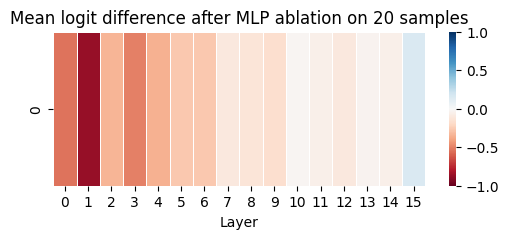

In [58]:
fig = plt.figure(figsize=(6, 2))
sns.heatmap(diff_arr_del.reshape(1, -1), cmap='RdBu', linewidths=0.5, vmin=-1, vmax=1)

plt.title("Mean logit difference after MLP ablation on 20 samples")
plt.xlabel("Layer")

plt.show()

In [59]:
diff_arr_switch = get_logit_diff_all_mlps_dataset(switch_end)

  0%|          | 0/20 [00:00<?, ?it/s]

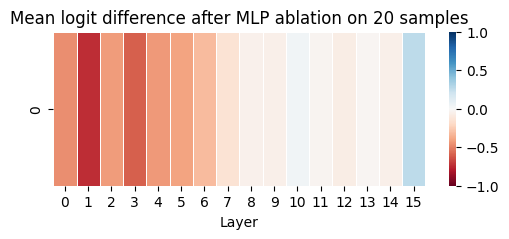

In [60]:
fig = plt.figure(figsize=(6, 2))
sns.heatmap(diff_arr_switch.reshape(1, -1), cmap='RdBu', linewidths=0.5, vmin=-1, vmax=1)

plt.title("Mean logit difference after MLP ablation on 20 samples")
plt.xlabel("Layer")

plt.show()

## Move typos to the start
The method above is not perfect, since I am considering everything apart from the whole correct word as incorrect. That means that even if the model generates the correct word, but split into mulitple tokens (this sometimes happen), I am counting that as incorrect.

To adress this issue, I will try to do the same thing, but with typos at the start of the word, so that the first token always means incorrect word.

In [89]:
switch_start = [
    ["incorrect: eclebration, correct:", " celebration"],  
    ["incorrect: ocmputer, correct:", " computer"],  
    ["incorrect: xeploring, correct:", " exploring"],  
    ["incorrect: ewather, correct:", " weather"],
    ["incorrect: tsatistical, correct:", " statistical"],
    ["incorrect: hpysics, correct:", " physics"],
    ["incorrect: ilght, correct:", " light"],
    ["incorrect: boesity, correct:", " obesity"],
    ["incorrect: ocnversation, correct:", " conversation"],
    ["incorrect: eclebration, correct:", " celebration"], 
    ["incorrect: miagination, correct:", " imagination"],  
    ["incorrect: ownderful, correct:", " wonderful"],  
    ["incorrect: tsorytelling, correct:", " storytelling"], 
    ["incorrect: escurity, correct:", " security"],
    ["incorrect: iwndow, correct:", " window"],  
    ["incorrect: htunder, correct:", " thunder"], 
    ["incorrect: cinnamon, correct:", " cinnamon"],  
    ["incorrect: hcocolate, correct:", " chocolate"],
    ["incorrect: awrrior, correct:", " warrior"],
    ["incorrect: ohrizon, correct:", " horizon"],  
]
print("len switch_end", len(switch_start))

len switch_end 20


In [92]:
# Verify that the model can correctly predict those
def verify_correctness_start(dataset: List[List[str]]):
    for text, correct in dataset:
        logits = model(text, return_type="logits")
        new_tok = logits[:, -1, :].argmax()
        prediction = model.to_string(new_tok)
        if prediction == correct:
            print(f"[CORRECT] predicted token: '{prediction}', correct word: '{correct}', sentence: {text}")
        else:
            if correct.startswith(prediction):
                print(f"[POSSIBLY CORRECT] predicted token: '{prediction}', correct word: '{correct}', sentence: {text}")
            else:
                print(f"[WRONG] predicted token: '{prediction}', correct word: '{correct}', sentence: {text}")


In [93]:
verify_correctness_start(switch_start)

[CORRECT] predicted token: ' celebration', correct word: ' celebration', sentence: incorrect: eclebration, correct:
[CORRECT] predicted token: ' computer', correct word: ' computer', sentence: incorrect: ocmputer, correct:
[CORRECT] predicted token: ' exploring', correct word: ' exploring', sentence: incorrect: xeploring, correct:
[CORRECT] predicted token: ' weather', correct word: ' weather', sentence: incorrect: ewather, correct:
[CORRECT] predicted token: ' statistical', correct word: ' statistical', sentence: incorrect: tsatistical, correct:
[CORRECT] predicted token: ' physics', correct word: ' physics', sentence: incorrect: hpysics, correct:
[CORRECT] predicted token: ' light', correct word: ' light', sentence: incorrect: ilght, correct:
[CORRECT] predicted token: ' obesity', correct word: ' obesity', sentence: incorrect: boesity, correct:
[CORRECT] predicted token: ' conversation', correct word: ' conversation', sentence: incorrect: ocnversation, correct:
[CORRECT] predicted to

In [95]:
add_incorrect_token(switch_start)

In [98]:
#sanity check
switch_start[2]

['incorrect: xeploring, correct:', ' exploring', ' xe']

In [99]:
diff_matrix_switch_start = get_logit_diff_all_heads_dataset(switch_start)

  0%|          | 0/20 [00:00<?, ?it/s]

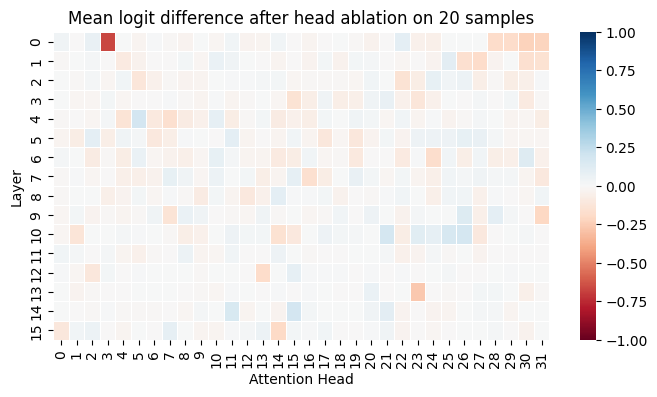

In [100]:
fig = plt.figure(figsize=(8, 4))
sns.heatmap(diff_matrix_switch_start, cmap="RdBu", linewidths=0.5, vmin=-1, vmax=1)

plt.title("Mean logit difference after head ablation on 20 samples")
plt.xlabel("Attention Head")
plt.ylabel("Layer")

plt.show()

The results are similar, but the L1H26 head doesn't have nearly that much influence. Head L13H23 also isn't as impactful as before, but is the second most important head. Lets visuale its attention patterns.

In [104]:
#text = switch_start[2][0]
text = "Induction test underway 1592305820385028493, Induction test underway 1592305820385028493"
visualize_attn_pattern(text, 13)

The head L13H23 is at least partially acting as induction head. This makes sense, since the current format kind of repeats some tokens in an induciton manner.